In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, measure
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#load image
img = Image.open("image2.tif")
img = np.asarray(img)

In [3]:
#convert rgb to grayscale, usign weighted sum
if len(img.shape) == 3 and img.shape[2] == 3:
    img = np.dot(img[..., :3], [0.2989, 0.587, 0.114]) 

In [4]:
#smoothing + thresholding
smoothed_image = gaussian_filter(img, sigma=1)

from skimage.filters import threshold_otsu
threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

Otsu's Threshold: 167.8986588893872


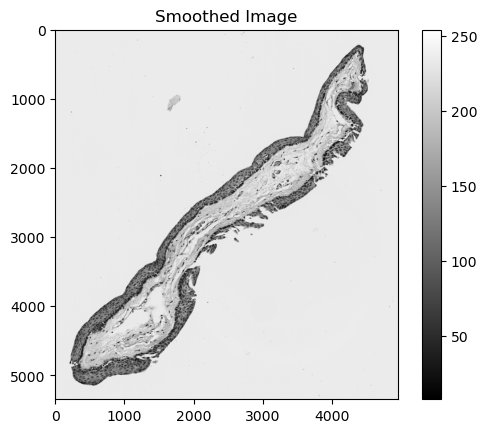

In [5]:
#segmenting
segmented_image = smoothed_image < threshold_value

plt.imshow(smoothed_image, cmap='gray')
plt.title("Smoothed Image")
plt.colorbar()
plt.show()

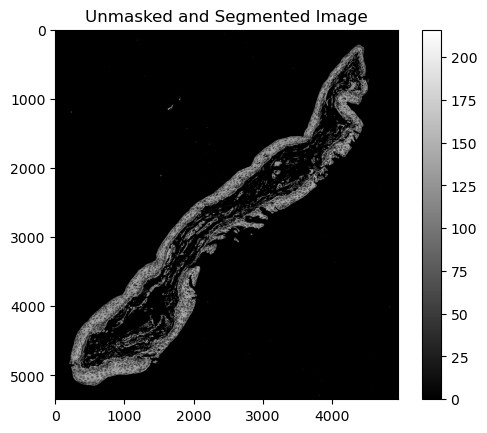

In [6]:
#unmasking
unmasked_image = np.zeros_like(img)
unmasked_image[segmented_image] = img[segmented_image]

plt.imshow(unmasked_image, cmap='gray')
plt.title("Unmasked and Segmented Image")
plt.colorbar()
plt.show()

In [7]:
#convert to 8-bit
binary_image = np.where(segmented_image, 255, 0).astype(np.uint8)


Number of contours found: 2988


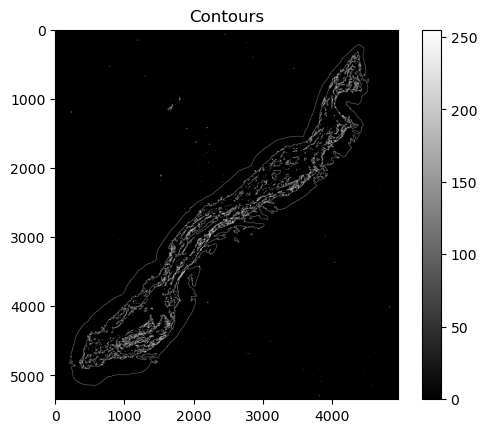

In [8]:
#identifying contours -- identifies the edges or boundaries of tissue layers
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours)}")

contour_image = np.zeros_like(binary_image)
cv2.drawContours(contour_image, contours, -1, 255, thickness=2)

plt.imshow(contour_image, cmap='gray')
plt.title("Contours")
plt.colorbar()
plt.show()

In [9]:
#filter contours by area
min_area = 1  #CALCULATE THRESHOLD??
max_area = 2000  #CALCULATE THRESHOLD?? -- need to figure out area

filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
print(f"Number of filtered contours (area-based): {len(filtered_contours)}")

Number of filtered contours (area-based): 2214


In [10]:
'''#draw contours on a blank canvas
filtered_contour_image = np.zeros_like(binary_image)
cv2.drawContours(filtered_contour_image, filtered_contours, -1, 255, thickness=2)

plt.imshow(filtered_contour_image, cmap='gray')
plt.title("Filtered Contours")
plt.colorbar()
plt.show()'''

'#draw contours on a blank canvas\nfiltered_contour_image = np.zeros_like(binary_image)\ncv2.drawContours(filtered_contour_image, filtered_contours, -1, 255, thickness=2)\n\nplt.imshow(filtered_contour_image, cmap=\'gray\')\nplt.title("Filtered Contours")\nplt.colorbar()\nplt.show()'

In [11]:
'''
#isolate  epithelium region based on the best contour match
if filtered_contours:
    #asssuming the epithelium is the contour with the largest area
    best_contour = max(filtered_contours, key=cv2.contourArea)

    #create a mask to isolate the epithelium region
    epithelium_mask = np.zeros_like(binary_image)
    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED)

    #apply the mask to isolate the epithelium from the original image
    isolated_epithelium = cv2.bitwise_and(unmasked_image, unmasked_image, mask=epithelium_mask)

    plt.imshow(isolated_epithelium, cmap='gray')
    plt.title("Isolated Epithelium Layer")
    plt.colorbar()
    plt.show()
else:
    print("No epithelium contour found")

'''

'\n#isolate  epithelium region based on the best contour match\nif filtered_contours:\n    #asssuming the epithelium is the contour with the largest area\n    best_contour = max(filtered_contours, key=cv2.contourArea)\n\n    #create a mask to isolate the epithelium region\n    epithelium_mask = np.zeros_like(binary_image)\n    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED)\n\n    #apply the mask to isolate the epithelium from the original image\n    isolated_epithelium = cv2.bitwise_and(unmasked_image, unmasked_image, mask=epithelium_mask)\n\n    plt.imshow(isolated_epithelium, cmap=\'gray\')\n    plt.title("Isolated Epithelium Layer")\n    plt.colorbar()\n    plt.show()\nelse:\n    print("No epithelium contour found")\n\n'

Otsu's Threshold: 167.8986588893872


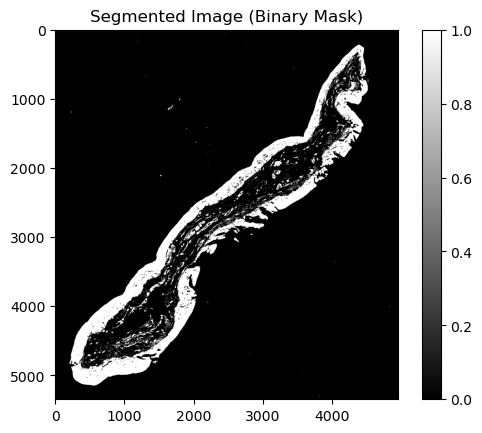

Number of contours found: 2988


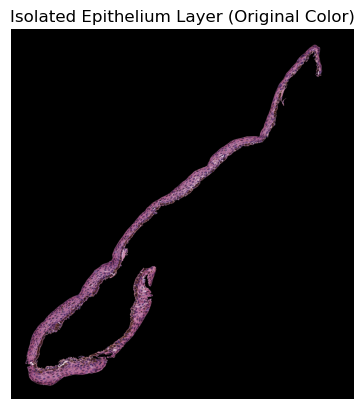

In [37]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2  


img = Image.open("image2.tif")
img = np.asarray(img)

original_color_image = img.copy()

if len(img.shape) == 3 and img.shape[2] == 3:
    img = np.dot(img[..., :3], [0.2989, 0.587, 0.114]) 

smoothed_image = gaussian_filter(img, sigma=1)

threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

segmented_image = smoothed_image < threshold_value

plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image (Binary Mask)")
plt.colorbar()
plt.show()

binary_image = np.where(segmented_image, 255, 0).astype(np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Number of contours found: {len(contours)}")

if len(contours) > 0:
    best_contour = max(contours, key=cv2.contourArea) 

    epithelium_mask = np.zeros_like(binary_image)  
    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED)  

    isolated_epithelium = np.zeros_like(original_color_image)
    isolated_epithelium[epithelium_mask == 255] = original_color_image[epithelium_mask == 255]

    plt.imshow(isolated_epithelium)
    plt.title("Isolated Epithelium Layer (Original Color)")
    plt.axis('off')
    plt.show()

else:
    print("No contours found.")


Otsu's Threshold: 187
Number of contours found: 869


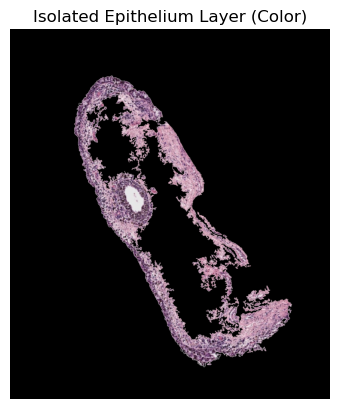

In [39]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2

img_color = Image.open("image1.tiff")
img_color = np.asarray(img_color)

img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

smoothed_image = gaussian_filter(img_gray, sigma=1)

threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

segmented_image = smoothed_image < threshold_value

binary_image = np.where(segmented_image, 255, 0).astype(np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Number of contours found: {len(contours)}")

if len(contours) > 0:
    best_contour = max(contours, key=cv2.contourArea)

    epithelium_mask = np.zeros_like(binary_image)  
    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED) 

    epithelium_layer_color = np.zeros_like(img_color)

    for i in range(3): 
        epithelium_layer_color[:, :, i] = np.where(epithelium_mask == 255, img_color[:, :, i], 0)

    plt.imshow(epithelium_layer_color)
    plt.title("Isolated Epithelium Layer (Color)")
    plt.axis('off')  
    plt.show()

    
else:
    print("No contours found.")


Otsu's Threshold: 164
Number of contours found: 18


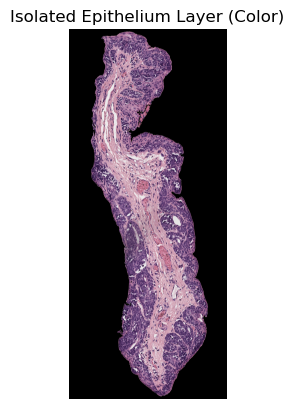

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2

img_color = Image.open("image3.tif")
img_color = np.asarray(img_color)

img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

smoothed_image = gaussian_filter(img_gray, sigma=1)

threshold_value = threshold_otsu(smoothed_image)
print("Otsu's Threshold:", threshold_value)

segmented_image = smoothed_image < threshold_value

binary_image = np.where(segmented_image, 255, 0).astype(np.uint8)

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Number of contours found: {len(contours)}")

if len(contours) > 0:
    best_contour = max(contours, key=cv2.contourArea)

    epithelium_mask = np.zeros_like(binary_image) 
    cv2.drawContours(epithelium_mask, [best_contour], -1, 255, thickness=cv2.FILLED) 

    epithelium_layer_color = np.zeros_like(img_color)

    for i in range(3):  
        epithelium_layer_color[:, :, i] = np.where(epithelium_mask == 255, img_color[:, :, i], 0)

    plt.imshow(epithelium_layer_color)
    plt.title("Isolated Epithelium Layer (Color)")
    plt.axis('off') 
    plt.show()

else:
    print("No contours found.")


In [ ]:
##WESITE


from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter
import numpy as np
import cv2  # Import OpenCV for contouring

# Step 1: Load the image
img = Image.open("image2.tif")
img = np.asarray(img)

# Step 2: Preserve the original RGB image for later use
original_color_image = img.copy()

# Convert the image to grayscale if it has 3 channels (RGB)
#if len(img.shape) == 3 and img.shape[2] == 3:
#    img = np.dot(img[..., :3], [0.2989, 0.587, 0.114])  # Convert RGB to grayscale using weighted sum


# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 3: Smooth the grayscale image
#smoothed_image = gaussian_filter(img, sigma=1)


# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
# visualize the binary image
#cv2.imshow('Binary image', thresh)
#cv2.waitKey(0)
#cv2.imwrite('image_thres1.jpg', thresh)
#cv2.destroyAllWindows()


# Step 4: Apply Otsu's thresholding to segment the image
#threshold_value = threshold_otsu(smoothed_image)
#print("Otsu's Threshold:", threshold_value)

# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
# draw contours on the original image
image_copy = image.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
                

plt.imshow(image_copy)
#plt.title("Isolated Epithelium Layer (Color)")
#plt.axis('off')  # Hide axes for better visualization
plt.show()
